<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Regression Trees**


Estimated time needed: **30** minutes


In this exercise session you will use a real dataset to train a regression tree model. The dataset includes information about taxi tip and was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). You will use the trained model to predict the amount of tip paid. 



## Objectives


After completing this lab you will be able to:


* Perform basic data preprocessing using Scikit-Learn
* Model a regression task using Scikit-Learn
* Train a Decision Tree Regressor model
* Run inference and assess the quality of the trained models


<h2>Introduction</h2>
The dataset used in this exercise session is a subset of the publicly available <a><href='https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page'>TLC Dataset</a> (all rights reserved by Taxi & Limousine Commission (TLC), City of New York). The prediction of the tip amount can be modeled as a regression problem. To train the model you can use part of the input dataset and the remaining data can be used to assess the quality of the trained model.
    <br>
</div>


<div id="import_libraries">
    <h2>Import Libraries</h2>
</div>


Make sure the libraries required are available by executing the cell below.


In [1]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Import the libraries we need to use in this lab


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

<div id="dataset_analysis">
    <h2>Dataset Analysis</h2>
</div>


In this section you will read the dataset in a Pandas dataframe and visualize its content. You will also look at some data statistics.

Note: A Pandas dataframe is a two-dimensional, size-mutable, potentially heterogeneous tabular data structure. For more information: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html.


In [3]:
# read the input data
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/pu9kbeSaAtRZ7RxdJKX9_A/yellow-tripdata.csv'
raw_data = pd.read_csv(url)
raw_data

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,tolls_amount,improvement_surcharge,tip_amount
0,2,1,17.63,2,1,132,164,1,70.0,0.5,6.94,1,16.54
1,2,1,19.52,2,1,132,236,1,70.0,0.5,6.94,1,16.19
2,2,1,17.81,2,1,132,48,1,70.0,0.5,6.94,1,12.00
3,2,2,19.30,2,1,132,148,1,70.0,0.5,0.00,1,5.00
4,2,1,18.75,2,1,132,234,1,70.0,0.5,6.94,1,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41197,2,1,16.94,2,1,132,164,1,70.0,0.5,6.94,1,5.00
41198,2,4,19.83,2,1,132,166,1,70.0,0.5,6.94,1,8.00
41199,2,1,17.31,2,1,132,137,1,70.0,0.5,6.94,1,8.00
41200,2,1,17.28,2,1,132,233,1,70.0,0.5,6.94,1,16.19


Each row in the dataset represents a taxi trip. As shown above, each row has 13 variables. One of the variables is `tip_amount` which will be the target variable. Your objective will be to train a model that uses the other variables to predict the value of the `tip_amount` variable.


To understand the dataset a little better, let us plot the correlation of the target variable against the input variables.


<Axes: >

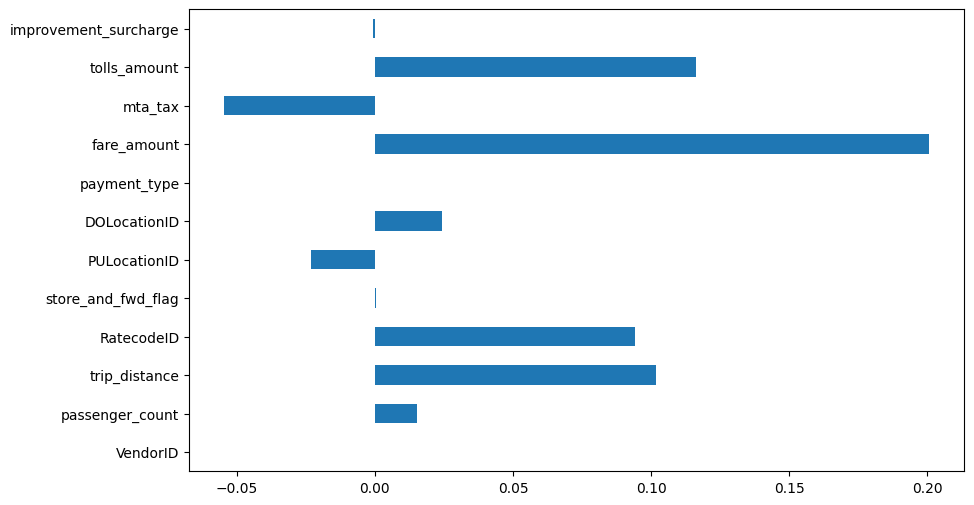

In [4]:
correlation_values = raw_data.corr()['tip_amount'].drop('tip_amount')
correlation_values.plot(kind='barh', figsize=(10, 6))

**What these two lines do:**

1. `correlation_values = raw_data.corr()['tip_amount'].drop('tip_amount')` — computes the Pearson correlation matrix for numeric columns in `raw_data`, selects the column of correlations with `tip_amount`, and drops the `tip_amount` self-correlation. The result is a pandas Series of correlation coefficients (one value per other feature) indicating direction and strength of linear association with `tip_amount`.

2. `correlation_values.plot(kind='barh', figsize=(10, 6))` — draws a horizontal bar chart of those correlation coefficients (using pandas/matplotlib). Positive bars mean positive correlation (feature increases → tip increases), negative bars mean inverse correlation, and bar length shows magnitude.

This visualization helps identify which features are most/least linearly related to the tip amount.

This shows us that the input features `payment_type`, `VendorID`, `store_and_fwd_flag` and `improvement_surcharge` have little to no correlation with the target variable.


<div id="dataset_preprocessing">
    <h2>Dataset Preprocessing</h2>
</div>


You will now prepare the data for training by applying normalization to the input features.


In [6]:
# extract the labels from the dataframe
y = raw_data[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
proc_data = raw_data.drop(['tip_amount'], axis=1)

# get the feature matrix used for training
X = proc_data.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

<div id="dataset_split">
    <h2>Dataset Train/Test Split</h2>
</div>


Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<div id="dt_sklearn">
    <h2>Build a Decision Tree Regressor model with Scikit-Learn</h2>
</div>


Regression Trees are implemented using `DecisionTreeRegressor`.

The important parameters of the model are:

`criterion`: The function used to measure error, we use 'squared_error'.

`max_depth` - The maximum depth the tree is allowed to take; we use 8.


In [8]:
# import the Decision Tree Regression Model from scikit-learn
from sklearn.tree import DecisionTreeRegressor

# for reproducible output across multiple function calls, set random_state to a given integer value
dt_reg = DecisionTreeRegressor(criterion = 'squared_error',
                               max_depth=8, 
                               random_state=35)

Now lets train our model using the `fit` method on the `DecisionTreeRegressor` object providing our training data


In [9]:
dt_reg.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,35
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


<div id="dt_sklearn_snapml">
    <h2>Evaluate the Scikit-Learn and Snap ML Decision Tree Regressor Models</h2>
</div>


To evaluate our dataset we will use the `score` method of the `DecisionTreeRegressor` object providing our testing data, this number is the $R^2$ value which indicates the coefficient of determination. We will also evaluate the Mean Squared Error $(MSE)$ of the regression output with respect to the test set target values. High $R^2$ and low $MSE$ values are expected from a good regression model.


In [10]:
# run inference using the sklearn model
y_pred = dt_reg.predict(X_test)

# evaluate mean squared error on the test dataset
mse_score = mean_squared_error(y_test, y_pred)
print('MSE score : {0:.3f}'.format(mse_score))

r2_score = dt_reg.score(X_test,y_test)
print('R^2 score : {0:.3f}'.format(r2_score))

MSE score : 24.555
R^2 score : 0.028


## Practice


Q1. What if we change the max_depth to 12? How would the $MSE$ and $R^2$ be affected? 

In [11]:
# Retrain with max_depth=12 and evaluate on the test set
from sklearn.tree import DecisionTreeRegressor

dt_reg12 = DecisionTreeRegressor(criterion='squared_error', max_depth=12, random_state=35)
dt_reg12.fit(X_train, y_train)

y_pred12 = dt_reg12.predict(X_test)
mse12 = mean_squared_error(y_test, y_pred12)
r2_12 = dt_reg12.score(X_test, y_test)
print(f'max_depth=12 -> MSE: {mse12:.3f}, R^2: {r2_12:.3f}')

max_depth=12 -> MSE: 26.459, R^2: -0.047


Typical effect: increasing max_depth to 12 raises model complexity. If the tree overfits, training error decreases while test MSE generally increases and test R^2 decreases (possibly becoming negative). Actual change depends on the dataset — run the cell above to observe the result for this data.

Q2. Identify the top 3 features with the most effect on the `tip_amount`.


Top 3 features by absolute Pearson correlation with tip_amount:
fare_amount: correlation=0.2006 (abs=0.2006)
tolls_amount: correlation=0.1162 (abs=0.1162)
trip_distance: correlation=0.1018 (abs=0.1018)


<Axes: title={'center': 'Top 3 features (abs correlation)'}>

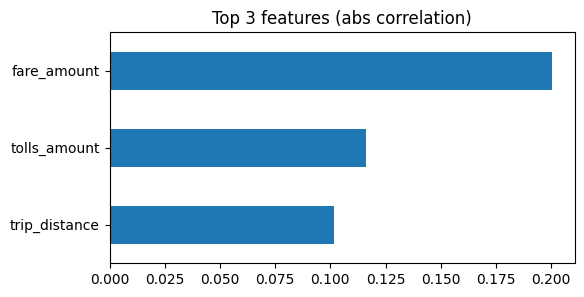

In [12]:
# Compute correlations with the target and get top 3 by absolute value
corr_vals = raw_data.corr()['tip_amount'].drop('tip_amount')
top3_abs = corr_vals.abs().sort_values(ascending=False).head(3)

print('Top 3 features by absolute Pearson correlation with tip_amount:')
for feat in top3_abs.index:
    print(f"{feat}: correlation={corr_vals[feat]:.4f} (abs={top3_abs[feat]:.4f})")

# optional: plot absolute correlations for the top 3
top3_abs.sort_values().plot(kind='barh', figsize=(6,3), title='Top 3 features (abs correlation)')

<details><summary>Click here for the solution</summary>

```python    
correlation_values = raw_data.corr()['tip_amount'].drop('tip_amount')
abs(correlation_values).sort_values(ascending=False)[:3]

```
<br>
As is evident from the output, Fare amount, toll amount and trip distance are the top features affecting the tip amount, which make logical sense.
</details>


Q3. Since we identified 4 features which are not correlated with the target variable, try removing these variables from the input set and see the effect on the $MSE$ and $R^2$ value.


In [13]:
# Drop low-correlation features and re-run preprocessing, training and evaluation
cols_to_drop = ['payment_type', 'VendorID', 'store_and_fwd_flag', 'improvement_surcharge']

# create a new dataframe with those columns removed
raw_data_dropped = raw_data.drop(cols_to_drop, axis=1)

# rebuild labels and features
y2 = raw_data_dropped[['tip_amount']].values.astype('float32')
proc_data2 = raw_data_dropped.drop(['tip_amount'], axis=1)
X2 = proc_data2.values

# normalize features (same as before)
X2 = normalize(X2, axis=1, norm='l1', copy=False)

# split (same random_state/test_size to allow fair comparison)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

# train a new decision tree with the same hyperparameters
dt_reg_dropped = DecisionTreeRegressor(criterion='squared_error', max_depth=8, random_state=35)
dt_reg_dropped.fit(X_train2, y_train2)

# evaluate
y_pred2 = dt_reg_dropped.predict(X_test2)
mse_dropped = mean_squared_error(y_test2, y_pred2)
r2_dropped = dt_reg_dropped.score(X_test2, y_test2)

# print comparison — baseline variables (mse_score, r2_score) were computed earlier
print(f'Baseline (original features) -> MSE: {mse_score:.3f}, R^2: {r2_score:.3f}')
print(f'After dropping features        -> MSE: {mse_dropped:.3f}, R^2: {r2_dropped:.3f}')

Baseline (original features) -> MSE: 24.555, R^2: 0.028
After dropping features        -> MSE: 24.709, R^2: 0.022


<details><summary>Click here for the solution</summary>

```python
raw_data = raw_data.drop(['payment_type', 'VendorID', 'store_and_fwd_flag', 'improvement_surcharge'], axis=1)

# Execute all the cells of the lab after modifying the raw data.
```
<br>
The MSE and $R^2$ values does not change significantly, showing that there is minimal affect of these parameters on the final regression output.
</details>


Q4. Check the effect of **decreasing** the `max_depth` parameter to 4 on the $MSE$ and $R^2$ values.


In [14]:
# Retrain with max_depth=4 and evaluate on the test set
from sklearn.tree import DecisionTreeRegressor

dt_reg4 = DecisionTreeRegressor(criterion='squared_error', max_depth=4, random_state=35)
dt_reg4.fit(X_train, y_train)

y_pred4 = dt_reg4.predict(X_test)
mse4 = mean_squared_error(y_test, y_pred4)
r2_4 = dt_reg4.score(X_test, y_test)

print(f'Baseline (max_depth=8) -> MSE: {mse_score:.3f}, R^2: {r2_score:.3f}')
print(f'max_depth=4             -> MSE: {mse4:.3f}, R^2: {r2_4:.3f}')

# Short note: decreasing max_depth reduces complexity; often test MSE decreases and R^2 increases if original model was overfitting.

Baseline (max_depth=8) -> MSE: 24.555, R^2: 0.028
max_depth=4             -> MSE: 24.412, R^2: 0.034


<details><summary>Click here for the solution</summary>
You will note that the MSE value decreases and $R^2$ value increases, meaning that the choice of `max_depth=4` may be more suited for this dataset.
</details>


### Congratulations! You're ready to move on to your next lesson!

## Author
<a href="https://www.linkedin.com/in/abhishek-gagneja-23051987/" target="_blank">Abhishek Gagneja</a>

### Other Contributors
<a href="https://www.linkedin.com/in/jpgrossman/" target="_blank">Jeff Grossman</a>  
 
<h3 align="center"> © IBM Corporation. All rights reserved. <h3/>

 
<!--
## Change Log
 
 
|  Date (YYYY-MM-DD) |  Version       | Changed By     | Change Description                  |
|---|---|---|---|
| 2024-10-31         | 3.0            | Abhishek Gagneja  | Rewrite                             |
| 2020-11-03         | 2.1            | Lakshmi        | Made changes in URL                 |
| 2020-11-03         | 2.1            | Lakshmi        | Made changes in URL                 |
| 2020-08-27         | 2.0            | Lavanya        | Moved lab to course repo in GitLab  |
|   |   |   |   |
